<a href="https://colab.research.google.com/github/benjaminbeilharz/annotated-transformer/blob/main/jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade jax optax datasets

In [ ]:
from typing import *
from tqdm import tqdm

# jax
import jax
import jax.numpy as jnp
import jax.random as random

# gradient processing + optimizers for the jax ecosystem
import optax as O

# data
from datasets import load_dataset

# enable colab tpu
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

# An Introduction to JAX

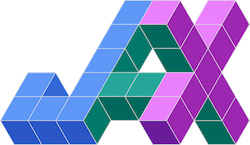

Let me start of with this questions:  
*Do you...*
- want to stop manually putting all the tensors and models on their devices?
- need easier paralellization?
- enjoy functional programming?
- want to stick closer to the math?

Then wait no more, we just got into `JAX`.
In this annotated notebook we quickly go over the basics of the newest contender in the computing world, and later be able to implement our own autoregressive language model (Transformer).

***


JAX is Autograd and XLA (is a compiler for highly optimized operations), at least that's what Google is telling us. It is used to enable high-performance machine learning research, or let's put it like this, any kind of numerical/scientific computing.  
JAX is able to automatically differentiate native Python and NumPy functions, whereas JAX has their own implementation included of NumPy, such that as long as you are familiar with NumPy, you will be as well with JAX.  
However LAX is now also targeting Google's Tensor Processing Units (TPU) which are custom hardware built for machine learning research, and thus highly optimized for linear algebra.

Some Caveats

- random generation works differently in JAX, we need to explicitly generate a `PRNGKey` which is equivalent to a numpy `seed`, however the state in PRNG is deterministic. If we need multiple keys, we need to split them. As everything with JAX, it will return the key and a new subkey (state and update), because you never use the same key twice.
- functional programming, no side effects allowed, this requires some change in how we think about our program's state. I strongly recommend reading [Thinking in Jax](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html).

But JAX offers more under the hood.  
Simple composable primitives for machine learning, just in time compilation and paralellization:
- `jax.numpy` is the NumPy interface that jax provides
- `jax.jit` compiles the supplied function just-in-time for an impressive speedup the function is used often
- `jax.grad` takes the first gradient of a function w.r.t. the first argument
- `jax.vmap` enables functions to become automatically vectorized versions of itself
- `jax.pmap` for simple paralellization, and differentiation across multiple devices

We will go through those primitives step by step to gain a better understanding of the underlying ideas which accompany them. Let's start with a short intro to functional programming and side effects.

## Side Effects

Side effects are everything that changes global program state. This can be as mere as changing a variable outside of a function, or mutating a given argument. JAX requires us to write pure functions, which do not change, or mutate global state. It takes some time to get used to, especially if you are used to other frameworks which like to keep a stateful context about the parameters as for example in `PyTorch`.

In [ ]:
# impure func #1
state_var = 0

def impure_one(): 
    global state_var
    print(state_var) 
    state_var += 2
    print(state_var)

def impure_two(x):
    print(x)
    x + 1
    print(x)

impure_one()
print(state_var)
impure_two(state_var)

0
2
2
2
2


In [ ]:
# this is fine, because we don't change the variable outside of the function but create a copy of the value
def pure_fn(x):
    new_var = x
    return x + 1

Overall I recommend 

## `jax.numpy`

The NumPy interface to JAX is similar to what we are used to when working with NumPy. Perhaps the biggest difference is, that JAX arrays are immutable by default, such that the following would result in an error:

In [ ]:
a = jnp.arange(1, 10)
print(a)
# this will cause an error because we are unable to change a vector inplace
try:
    a[-1] = jnp.arange(1, 3)
except TypeError as e:
    print('Mutation is bad')
    print(e)

# this on the other hand is fine if we really need to manipulate arrays in place:
a = a.at[-1].set(0)
print(a)

[1 2 3 4 5 6 7 8 9]
Mutation is bad
'<class 'jax._src.device_array._DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html
[1 2 3 4 5 6 7 8 0]


We can do matrix operations just like we used to do with NumPy

In [ ]:
key = jax.random.PRNGKey(42)
a = jax.random.randint(key, (3, 3), -1, 1)
b = jax.random.randint(key, (3, 5), -1, 1)
c = jnp.ones((3, 5))

jax.nn.softmax(a @ b + c, axis=-1)

DeviceArray([[0.11853155, 0.11853155, 0.11853155, 0.32220268, 0.32220268],
             [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
             [0.16430707, 0.06044517, 0.16430707, 0.44663367, 0.16430707]],            dtype=float32)

So we have just done some plain old feed forward as we do all the time.  
Other than the mentioned immutability, JAX arrays can be used almost the same as NumPy arrays with other packages.

## `jax.jit`
To gain a speedup we can compile functions so subsequent calls are faster.
Let's look at a quick benchmark.  
For further reading check out [JAX vs NumPy](https://jax.readthedocs.io/en/latest/faq.html#faq-jax-vs-numpy).

In [ ]:
import numpy as np

In [ ]:
x = np.random.normal(size=(2000, 3000)).astype(np.float32)
%timeit np.dot(x, x.T)

1 loop, best of 5: 412 ms per loop


Let's compare an unjitted JAX and jitted JAX example.

In [ ]:
x = random.uniform(key, (2000, 3000), minval=-1, maxval=1)

In [ ]:
# unjitted
%timeit jnp.dot(x, x.T).block_until_ready()

The slowest run took 161.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.91 ms per loop


In [ ]:
# jitted first exec
jitdot = jax.jit(jnp.dot)
%timeit jitdot(x, x.T).block_until_ready()

The slowest run took 138.88 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 5.2 ms per loop


In [ ]:
# jitted second exec
%timeit jitdot(x, x.T).block_until_ready()

100 loops, best of 5: 5.38 ms per loop


## `jax.grad`

Gradients are key concepts in the world of neural networks. We use them in backpropagation to actually be able to adjust the parameters by their error. Taking the gradient in JAX is as simple as calling just another function and is a core primitive in the JAX ecosystem.  
`jax.grad` wraps another function and computes the gradients with respect to the first function parameter. Let's take this small neural net below as an example.

In [ ]:
def relu(x):
  return jnp.maximum(0, x)

def predict(params, img):
    from jax.scipy.special import logsumexp
    # per-example predictions
    activations = img
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
  
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# random init for params
def random_layer_params(m, n, key, scale=1e-1):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# remember we will take the gradient w.r.t. the first parameter
def loss(params, img, tgt):
    preds = predict(params, img)
    return -jnp.mean(preds * tgt)

In [ ]:
layer_sizes = [144, 288, 288, 10]
target = jnp.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=jnp.float32)
params = init_network_params(layer_sizes, random.PRNGKey(0))
image = random.normal(random.PRNGKey(1), (12 * 12,))
preds = predict(params, image)
print(preds.shape)

(10,)


In [ ]:
jax.grad(loss)(params, image, target)

[(DeviceArray([[ 2.6296640e-03,  8.4307256e-05,  1.0911950e-03, ...,
                -2.3939245e-04,  1.4109161e-03, -6.5495161e-04],
               [-1.3404343e-02, -4.2974442e-04, -5.5622132e-03, ...,
                 1.2202694e-03, -7.1919467e-03,  3.3385239e-03],
               [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
                 0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
               ...,
               [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
                 0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
               [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
                 0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
               [ 4.0973131e-02,  1.3136022e-03,  1.7002048e-02, ...,
                -3.7300042e-03,  2.1983664e-02, -1.0204884e-02]],            dtype=float32),
  DeviceArray([-1.43490918e-03,  7.31424801e-03,  0.00000000e+00,
                0.00000000e+00,  9.74586525e-04, -1.89102720e-05,
               -

## `jax.vmap`
vmap can be used to automatically produce a function that is operating on a batch, rather than just a sample.  
vmap adds an extra dimension to the function (usually the batch size) to process multiple samples at once with no change required in the function itself. Therefore:  

$$f(x), \text{where } x \in \mathbb{R}^{n \times m} \\
vmap(f(x)), \text{where } x \in \mathbb{R}^{* \times n \times m}$$

Let's batch our example from above.

In [ ]:
random_flattened_images = random.normal(random.PRNGKey(1), (10, 12 * 12))
try:
    predict(params, random_flattened_images)
except TypeError as e:
    print('This does not support batching')
    print(e)

This does not support batching
Incompatible shapes for dot: got (288, 144) and (10, 144).


In [ ]:
batch_predict = jax.vmap(predict, in_axes=(None, 0))
batch_predict(params, random_flattened_images)

DeviceArray([[-1.9015684 , -0.7690184 , -4.346179  , -2.9666512 ,
              -2.9935122 , -4.502557  , -3.7568974 , -3.277829  ,
              -4.484718  , -1.664767  ],
             [-2.4899907 , -1.3559425 , -3.694668  , -2.671898  ,
              -0.74987197, -5.108794  , -3.279263  , -5.8442473 ,
              -3.9866915 , -3.5818477 ],
             [-1.430965  , -3.5687988 , -0.6901064 , -3.920475  ,
              -2.3820539 , -3.928277  , -4.6724195 , -3.3987353 ,
              -3.2485986 , -4.031564  ],
             [-1.431176  , -2.502234  , -1.4176011 , -4.53675   ,
              -2.3397255 , -4.204099  , -2.2941158 , -3.9822793 ,
              -2.5264204 , -2.1598556 ],
             [-0.68175745, -3.3978493 , -2.1756425 , -3.368552  ,
              -2.4247975 , -5.186468  , -2.481913  , -3.6203594 ,
              -4.0739903 , -2.3925104 ],
             [-2.0613995 , -1.8863201 , -0.7786894 , -6.184161  ,
              -1.915925  , -5.25496   , -5.0345583 , -4.1975017 ,
   

## `jax.pmap`

To parallelize the computation across devices we can use `pmap`. It is analogous with `vmap`, just that it spreads the batch across devices. Let's take a look at the sample above running on multiple TPU cores (GPUS work as well, Colab just provides one).

In [ ]:
# let's check for devices/TPU cores
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
# let's set the var for the number of devices available
n_devices = jax.local_device_count()
n_devices

8

In [ ]:
images_for_devices = random.normal(random.PRNGKey(1), (n_devices, 12 * 12))

# lets replicate weights
replicate_weights = lambda x: jnp.broadcast_to(x, (n_devices, ) + x.shape)
params_for_devices = jax.tree_map(replicate_weights, params)

jax.pmap(predict, axis_name='batch')(params_for_devices, images_for_devices)

ShardedDeviceArray([[-2.0198154 , -1.9559671 , -1.8922449 , -1.533138  ,
                     -2.0705414 , -5.1176844 , -1.823818  , -3.3323402 ,
                     -4.085059  , -4.323161  ],
                    [-2.5576596 , -1.483922  , -0.89954543, -3.9350405 ,
                     -3.1721997 , -5.3697085 , -1.8071759 , -3.259179  ,
                     -5.6385245 , -4.086642  ],
                    [-2.3339736 , -2.338798  , -1.8960398 , -3.9682643 ,
                     -2.5795531 , -2.4005284 , -2.0761194 , -3.6529276 ,
                     -3.049448  , -1.3005831 ],
                    [-1.6225648 , -2.0156941 , -2.833335  , -4.3311186 ,
                     -0.54992485, -4.5912037 , -4.9597125 , -8.063543  ,
                     -8.015085  , -5.950221  ],
                    [-1.3082542 , -3.6305807 , -2.809523  , -2.851048  ,
                     -2.2890854 , -1.8557265 , -2.9675677 , -2.4283717 ,
                     -1.8484926 , -3.4933033 ],
                    [-2.983853

We see that we no longer get a `DeviceArray` but rather a `ShardedDeviceArray` which means we actually distributed our samples across devices.  
Every operation in `jax.lax`, which is the module containing all underlying implementations for the operators in jax, that starts with p, is a paralellized version.

## Transformer Language Model

In [ ]:
class Module:
    """Common class to store parameters for each of the modules and
    purify functions with side effects to have none"""
    _submodules: Dict[str, 'Module']
    _params: Dict[str, jnp.ndarray]

    def __init__(self):
        self._params = {}
        self._submodules = {}
    
    def __getattr__(self, attr_name: str):
        if attr_name in self._params:
            return self._params[attr_name]
        elif attr_name in self._submodules:
            return self._submodules[attr_name]
        else:
            return self.__dict__[attr_name]
    
    def __setattr__(self, key: str, value: Any):
        if isinstance(value, Module):
            self._submodules[key] = value
        elif isinstance(value, jnp.ndarray):
            self._params[key] = value
        else:
            self.__dict__[key] = value

    def _clear_params(self):
        self._params = {}
        for submodule in self._submodules.values():
            submodule._clear_params()
    
    def get_params(self) -> Mapping[str, jnp.ndarray]:
        """Retrieve all parameters"""
        params = self._params.copy()
        for submodule_name, submodule in self._submodules.items():
            for name, value in submodule.get_params().items():
                params[f'{submodule_name}/{name}'] = value
        return params
    
    def _set_params(self, params: Mapping[str, jnp.ndarray]):
        for name, value in params.items():
            self._set_param(name.split('/'), value)

    def _set_param(self, param_path: List[str], value: jnp.ndarray):
        if len(param_path) == 1:
            self._params[param_path[0]] = value
        else:
            self._submodules[param_path[0]]._set_param(param_path[1:], value)

    def purify(self, method: Callable) -> Callable:
        """Takes a function and cures it from its side effects"""
        def pure_method(params: Mapping[str, jnp.ndarray], *args):
            self._clear_params()
            self._set_params(params)
            result = method(*args)
            return result
        return pure_method

M = TypeVar('M', bound=Module)
class ModuleList(Module, Generic[M]):
    """Class to store multiple modules and their parameters"""
    _submodules: List[M]

    def __init__(self, modules: List[M]):
        super().__init__()
        self._submodules = modules

    def __getitem__(self, idx: int) -> M:
        return self._submodules[idx]
    
    def _setitem__(self, key, value):
        raise NotImplementedError

    def __len__(self):
        return len(self._submodules)

    def __getattr__(self, item):
        return self.__dict__(item)
    
    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def _clear_params(self):
        self._params = {}
        for submodule in self._submodules:
            submodule._clear_params()

    def get_params(self):
        params = self._params
        for i, submodule in enumerate(self._submodules):
            for name, value in submodule.get_params().items():
                params[f'{i}/{name}'] = value
        return params

    def _set_param(self, param_path: List[str], value: jnp.ndarray):
        self._submodules[int(param_path[0])]._set_param(param_path[1:], value)

In [ ]:
class Embedding(Module):
    """Embedding Class"""
    def __init__(self, rnd_key: jax.random.PRNGKey, n_embeddings: int, n_dim: int):
        super().__init__()
        self.embeddings = jax.random.normal(rnd_key, (n_embeddings, n_dim))
    
    def __call__(self, ids: jnp.ndarray):
        return self.embeddings[ids, :]

class PositionalEmbedding(Module):
    """Learned positional embeddings"""
    def __init__(self, rnd_key: jax.random.PRNGKey, 
                 n_vocab: int, 
                 d_model: int, 
                 max_len: int = 4096):
        """
        Args: 
            rnd_key - jax random key
            n_vocab - vocab size
            d_model - hidden dimension
            max_len - length of positional encoding
        """
        super().__init__()
        self.embeddings = Embedding(rnd_key, n_vocab, d_model)
        self.coef = 1 / d_model ** .5
        self.encoding = jnp.zeros((max_len, d_model))

    def __call__(self, x: jnp.ndarray):
        pe = self.encoding[:x.shape[0]]
        return self.embeddings(x) * self.coef + pe

In [ ]:
class Linear(Module):
    """Fully connected Layer"""
    def __init__(self, rnd_key: jax.random.PRNGKey, in_features: int, out_features: int):
        """
        Args:
            rnd_key: jax random key
            in_features: number of incoming dimensions
            out_features: number of outgoing dimensions
        """
        super().__init__()
        rnd_range = 1 / in_features ** .5
        self.weight = jax.random.uniform(rnd_key, (in_features, out_features),
                                         minval=-rnd_range, maxval=rnd_range)
        self.bias = jnp.zeros((out_features, ))

    def __call__(self, x: jnp.ndarray):
        return jnp.matmul(x, self.weight) + self.bias


class LayerNorm(Module):
    """Layer Normalization"""
    def __init__(self, normalized_shape: Union[Tuple[int], List[int]], 
                 eps: float = 1e-5, 
                 elementwise_affine: bool = True):
        """
        Args:
            normalized_shape - shape of hidden dimensions
            eps - stabilizing factor
            elementwise_affine - learn additional parameter
        """
        super().__init__()
        self.eps = eps 
        self.elementwise_affine = elementwise_affine
        self.normalized_shape = tuple(normalized_shape)

        if elementwise_affine:
            self.gain = jnp.ones(normalized_shape)
            self.bias = jnp.zeros(normalized_shape)
    
    def __call__(self, x: jnp.ndarray):
        assert self.normalized_shape == x.shape[-len(self.normalized_shape):]
        axes = [-(i+1) for i in range(len(self.normalized_shape))]
        mean = x.mean(axis=axes, keepdims=True)
        mean_x2 = (x ** 2).mean(axis=axes, keepdims=True)
        variance = mean_x2 - mean ** 2
        x_norm = (x - mean) / (variance + self.eps) ** .5

        if self.elementwise_affine:
            x_norm = self.gain * x_norm + self.bias
        
        return x_norm

In [ ]:
class PreSelfAttention(Module):
    """Creates QKV matrices"""
    def __init__(self, rnd_key: jax.random.PRNGKey, d_model: int, heads: int, d_k: int):
        """
        Args:
            rnd_key - jax random key
            d_model - embedding dim
            heads - nheads
            d_k - dimension of heads
        """

        super().__init__()
        self.linear = Linear(rnd_key, d_model, heads * d_k)
        self.heads = heads
        self.d_k = d_k
    
    def __call__(self, x: jnp.ndarray):
        head_shape = x.shape[:-1]
        x = self.linear(x)
        x = x.reshape(*head_shape, self.heads, self.d_k)
        return x

class SelfAttention(Module):
    """Masked SelfAttention"""
    def __init__(self, rnd_key: jax.random.PRNGKey, nheads: int, d_model: int):
        """
        Args:
            rnd_key - jax random key
            nheads - number of heads
            d_model - embedding dim
        """
        super().__init__()
        _, *rnd_keys = jax.random.split(rnd_key, 5)
        self.d_k = d_model // nheads
        self.nheads = nheads

        # prepare matrices
        self.query = PreSelfAttention(rnd_keys[0], d_model, nheads, self.d_k)
        self.key = PreSelfAttention(rnd_keys[1], d_model, nheads, self.d_k)
        self.value = PreSelfAttention(rnd_keys[2], d_model, nheads, self.d_k)

        self.output = Linear(rnd_keys[3], d_model, d_model)
        self.scale = 1 / self.d_k ** .5

    def __call__(self, query: jnp.ndarray,
                 key: jnp.ndarray,
                 value: jnp.ndarray,
                 mask: Optional[jnp.ndarray] = None):
        seq_len = len(query)

        if mask is not None:
            assert mask.shape[0] == query.shape[0]
            assert mask.shape[1] == key.shape[0]
            mask = mask[:, :, None]
        
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # equivalent to jnp.matmul(query, key.T)
        scores = jnp.einsum('ihd,jhd->ijh', query, key)
        scores *= self.scale

        if mask is not None:
            scores = scores + (mask == 0) * float('-inf')
        
        attn = jax.nn.softmax(scores, axis=1)

        # equivalent to jnp.matmul(attn, values) 
        x = jnp.einsum('ijh,jhd->ihd', attn, value)
        x = x.reshape(seq_len, -1)
        return self.output(x)

In [ ]:
class FeedForward(Module):
    """Feed Forward Block"""
    def __init__(self, rnd_key: jax.random.PRNGKey, d_model: int, d_ff: int, activation=jax.nn.relu):
        """
        Args:
            rnd_key - jax random key
            d_model - embedding dim
            d_ff - projection size
            activation - activation functions
        """
        super().__init__()
        _, *rnd_keys = jax.random.split(rnd_key, 5)
        self.layer1 = Linear(rnd_keys[0], d_model, d_ff)
        self.layer2 = Linear(rnd_keys[1], d_ff, d_model)
        self.activation = activation

    def __call__(self, x: jnp.ndarray):
        x = self.activation(self.layer1(x))
        return self.layer2(x)

In [ ]:
class TransformerBlock(Module):
    """Transformer Block"""
    def __init__(self, d_model: int, self_attn: SelfAttention, feed_forward: FeedForward):
        """
        Args:
            d_model - embedding dim
            self_attn - attention module
            feed_forward - feed forward module
        """
        super().__init__()
        self.size = d_model
        self.attn = self_attn
        self.feed_forward = feed_forward
        self.norm_attn = LayerNorm([d_model])
        self.norm_ff = LayerNorm([d_model])

    def __call__(self, x: jnp.ndarray, mask: jnp.ndarray):
        z = self.norm_attn(x)
        self_attn = self.attn(query=z,
                              key=z,
                              value=z,
                              mask=mask)
        # residual
        x = x + self_attn
        z = self.norm_ff(x)
        ff = self.feed_forward(z)
        x = x + ff
        return x

In [ ]:
class CrossEntropyLoss(Module):
    def __init__(self):
        super().__init__()
        self._loss_vmap = jax.vmap(self._loss, in_axes=(0, 0,))

    def _loss(self, output: jnp.ndarray, tgt: jnp.ndarray):
        return -jax.nn.log_softmax(output)[tgt]
    
    def __call__(self, output: jnp.ndarray, tgt: jnp.ndarray):
        return self._loss_vmap(output, tgt).mean()

In [ ]:
class LanguageModelTransformer(Module):
    """Language Model"""
    layers: ModuleList[TransformerBlock]

    def __init__(self, rnd_key: jax.random.PRNGKey,
                 vocab: int,
                 d_model: int,
                 n_layers: int,
                 n_heads: int,
                 d_ff: int):
        """
        Args:
            rnd_key - jax random key
            vocab - vocab size
            d_model - embedding dim
            n_layers - number of `TransformerBlocks`
            n_heads - number of attention heads
            d_ff - feed forward projection dim
        """
        super().__init__()
        self.vocab = vocab
        self.d_model = d_model
        self.loss_func = CrossEntropyLoss()

        layers = [] 
        for i in range(n_layers):
            rnd_key, selfattn_key, ffn_key = jax.random.split(rnd_key, 3)
            attn = SelfAttention(selfattn_key, n_heads, d_model)
            ffn = FeedForward(ffn_key, d_model, d_ff)
            layers.append(TransformerBlock(d_model, attn, ffn))

        self.layers = ModuleList(layers)
        rnd_key, emb_key, out_key = jax.random.split(rnd_key, 3)
        self.embeddings = PositionalEmbedding(emb_key, vocab, d_model)
        self.norm = LayerNorm([d_model])
        self.output = Linear(out_key, d_model, vocab)

    def __call__(self, x: jnp.ndarray):
        seq_len = len(x)
        # triangular mask to learn autoregressively
        mask = jnp.tril(jnp.ones((seq_len, seq_len), bool))

        x = self.embeddings(x)
        for i, _ in enumerate(self.layers):
            x = self.layers[i](x, mask)

        return self.output(self.norm(x))

    def get_loss(self, x: jnp.ndarray):
        """Calculate loss by using the current token predicting 
        the next token in the sequence"""
        output = self(x)
        return self.loss_func(output[:-1], x[1:])

    def sample(self, seq: jnp.ndarray, length: int = 50):
        """Generate a random sequence by greedy decoding"""
        for i in range(length):
            idx = jnp.argmax(self(seq)[-1])
            seq = jnp.concatenate((seq, idx[None]))
        return seq

In [ ]:
class Dataset:
    def __init__(self, rnd_key: jax.random.PRNGKey, seq_len: int, batch_size: int):
        self.batch_size = batch_size
        _, self.rnd_key = jax.random.split(rnd_key)

        self.data = load_dataset('empathetic_dialogues', split='train')['utterance']
        vocab = sorted(list(set(' '.join(self.data))))
        self.size = len(vocab)

        # create character-based vocab
        self.stoi = {t: i for i, t in enumerate(vocab)}
        self.itos = vocab
        
        samples = jnp.array([self.stoi[c] for sentence in self.data for c in sentence])  
        self.n_batches = len(samples) // (seq_len * batch_size)
        data = samples[:self.n_batches * seq_len * batch_size]
        self.data = data.reshape((-1, seq_len))
        self.idx = jnp.arange(len(self.data))

    def __iter__(self):
        self._iter_idx = 0
        self.rnd_key, rnd_key = jax.random.split(self.rnd_key)
        self.idx = jax.random.permutation(rnd_key, self.idx)
        return self

    def __len__(self):
        return self.n_batches

    def __next__(self):
        if self._iter_idx >= self.n_batches:
            raise StopIteration()
        
        idx = self.idx[self._iter_idx * self.batch_size: (self._iter_idx + 1) * self.batch_size]
        self._iter_idx += 1
        return self.data[idx]

In [ ]:
rnd_key = jax.random.PRNGKey(42)
dataset = Dataset(rnd_key, seq_len=32, batch_size=128)

Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Dataset empathetic_dialogues downloaded and prepared to /root/.cache/huggingface/datasets/empathetic_dialogues/default/0.1.0/09bbeed3882a67db98c73952fb3c1c9a85af83dc78f81454c2454382fd03f6cf. Subsequent calls will reuse this data.


In [ ]:
model = LanguageModelTransformer(rnd_key, dataset.size, d_model=128, n_layers=3, n_heads=8, d_ff=512)

In [ ]:
params = model.get_params()

# purify, vmap and jit functions
pure_sample_fn = jax.jit(model.purify(model.sample))
pure_forward_fn = jax.jit(jax.vmap(model.purify(model.__call__), in_axes=(None, 0), out_axes=0))
pure_loss_fn = jax.jit(jax.vmap(model.purify(model.get_loss), in_axes=(None, 0), out_axes=0))

# updated loss function
def get_loss(params, seq):
    return pure_loss_fn(params, seq).mean()

grad_loss_fn = jax.jit(jax.grad(get_loss, argnums=0))

In [ ]:
# optax (gradient processing for jax)
optimizer = O.adam(1e-4)
opt_state = optimizer.init(params)

In [ ]:
def generate_sample(params, prompt: str) -> str:
    """Generates a sample given a prompt"""
    encoded = [dataset.stoi[c] for c in prompt]
    sampled = pure_sample_fn(params, jnp.array(encoded))[len(encoded):]
    sampled = ''.join([dataset.itos[i] for i in sampled])
    sampled = sampled.replace('\n', '\\n')
    return prompt + sampled

In [ ]:
for epoch in range(0, 2):
    with tqdm(total=len(dataset)) as pbar:
        for i, data in enumerate(dataset):
            loss = get_loss(params, data)
            grads = grad_loss_fn(params, data)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = O.apply_updates(params, updates)
            pbar.update(1)

            if i % 50 == 0:
                print(f'\tLoss: ', loss)
                prompt = __import__('random').choice(['I', 'This', 'Why'])
                sampled = generate_sample(params, prompt)
                print(f'Generation: {prompt} {sampled}')
    

  0%|          | 1/1657 [00:03<1:25:11,  3.09s/it]

	Loss:  2.4030607
Generation: This This at and to the the the the the the the the the the


  3%|▎         | 51/1657 [02:08<1:07:35,  2.53s/it]

	Loss:  2.3759272
Generation: I I to the the the the the the the the the the the th


  6%|▌         | 101/1657 [05:53<1:05:01,  2.51s/it]

	Loss:  2.283505
Generation: I I was to the the the the the the the the the the th


  9%|▉         | 151/1657 [07:57<1:00:40,  2.42s/it]

	Loss:  2.297039
Generation: This This at and to the the the the the the the the the the


 12%|█▏        | 201/1657 [09:58<58:25,  2.41s/it]

	Loss:  2.2494583
Generation: Why Why at the the the the the the the the the the the th


 15%|█▌        | 251/1657 [13:42<58:42,  2.51s/it]

	Loss:  2.2034698
Generation: I I was to the the the the the the there the the ther


 18%|█▊        | 301/1657 [15:46<58:25,  2.59s/it]

	Loss:  2.1353998
Generation: This This at the the the the the the the the the the the th


 21%|██        | 351/1657 [17:52<52:44,  2.42s/it]

	Loss:  2.1396492
Generation: Why Why at the the the the the the the the the the the th


 24%|██▍       | 401/1657 [19:55<51:08,  2.44s/it]

	Loss:  2.114935
Generation: This This at and the the the the the the the the the the th


 27%|██▋       | 451/1657 [22:00<51:14,  2.55s/it]

	Loss:  2.0355299
Generation: Why Why that to the the the the the the the the the the t


 30%|███       | 501/1657 [24:03<48:41,  2.53s/it]

	Loss:  2.10059
Generation: This This sould the a to the the the the the theare t thear


 33%|███▎      | 551/1657 [26:09<48:24,  2.63s/it]

	Loss:  2.0322497
Generation: I I was a to the the the the the they they arear t th


 36%|███▋      | 601/1657 [28:12<41:48,  2.38s/it]

	Loss:  1.9251583
Generation: I I was a to to the the the the the the are the the a


 39%|███▉      | 651/1657 [30:14<41:02,  2.45s/it]

	Loss:  1.8984014
Generation: Why Why do the to the to the to the the the ane the the t


 42%|████▏     | 701/1657 [32:17<40:51,  2.56s/it]

	Loss:  1.8901196
Generation: This This so to ther too the they are arear the thear are t


 45%|████▌     | 751/1657 [34:19<37:03,  2.45s/it]

	Loss:  1.9105884
Generation: I I have a so that a so the a so thear are areallllll


 48%|████▊     | 801/1657 [36:24<35:59,  2.52s/it]

	Loss:  1.8824006
Generation: Why Why do do the the the the the theane the the the ane 


 51%|█████▏    | 851/1657 [38:35<38:01,  2.83s/it]

	Loss:  1.8137612
Generation: I I was a so that a so the some thear a theare thind 


 54%|█████▍    | 901/1657 [40:45<32:22,  2.57s/it]

	Loss:  1.8633877
Generation: Why Why do do the the they and the theat ine ind it ithe 


 57%|█████▋    | 951/1657 [42:51<29:29,  2.51s/it]

	Loss:  1.8348589
Generation: I I was a so a so and a the a some thind arrrre are a


 60%|██████    | 1001/1657 [44:55<26:40,  2.44s/it]

	Loss:  1.7521099
Generation: I I was a so to the to the to the t are are tthe are 


 63%|██████▎   | 1051/1657 [47:00<25:28,  2.52s/it]

	Loss:  1.6947234
Generation: This This so so to the to the to the the the theare ttthe t


 66%|██████▋   | 1101/1657 [49:05<22:53,  2.47s/it]

	Loss:  1.7495937
Generation: This This so so so the a some the a theare thind thind ind 


 69%|██████▉   | 1151/1657 [51:09<20:43,  2.46s/it]

	Loss:  1.7331746
Generation: This This so a so the a so the will theay asthe the the the


 72%|███████▏  | 1201/1657 [53:15<19:14,  2.53s/it]

	Loss:  1.7883998
Generation: This This so so there the will the washee theast t theast i


 75%|███████▌  | 1251/1657 [55:18<16:41,  2.47s/it]

	Loss:  1.7617415
Generation: This This so so the a so the a the tourearst thind indeare 


 79%|███████▊  | 1301/1657 [57:21<15:15,  2.57s/it]

	Loss:  1.6397512
Generation: Why Why do the the was and the the theare theare ttttthe 


 82%|████████▏ | 1351/1657 [59:28<12:48,  2.51s/it]

	Loss:  1.7074205
Generation: This This so the work the the wore theand theand the the th


 85%|████████▍ | 1401/1657 [1:01:32<10:37,  2.49s/it]

	Loss:  1.7043432
Generation: I I had to my friend to my friend iest ie t t theat i


 88%|████████▊ | 1451/1657 [1:03:39<08:47,  2.56s/it]

	Loss:  1.5989954
Generation: Why Why do the was and the was a gooood t t t thearke the


 91%|█████████ | 1501/1657 [1:05:42<06:17,  2.42s/it]

	Loss:  1.6823014
Generation: Why Why do do the was and the was a the thea the theare t


 94%|█████████▎| 1551/1657 [1:07:47<04:29,  2.55s/it]

	Loss:  1.6678592
Generation: Why Why do do the do the do the do theade idesthid ide id


 97%|█████████▋| 1601/1657 [1:09:57<02:16,  2.44s/it]

	Loss:  1.6174314
Generation: I I have the to say are the some arearvearvend thinea


100%|█████████▉| 1651/1657 [1:12:00<00:14,  2.46s/it]

	Loss:  1.6610218
Generation: This This a so so so so and the will the the the theathe y 


  0%|          | 1/1657 [00:02<1:10:03,  2.54s/it]

	Loss:  1.6134192
Generation: I I had to my friend to me so hearssse in in in ind i


  3%|▎         | 51/1657 [02:08<1:08:18,  2.55s/it]

	Loss:  1.6550312
Generation: I I had to make the the was the soureee t theaneeee t


  6%|▌         | 101/1657 [04:13<1:04:03,  2.47s/it]

	Loss:  1.6220365
Generation: Why Why do you do the do the was to the thealllllllllle t


  9%|▉         | 151/1657 [06:18<1:04:58,  2.59s/it]

	Loss:  1.6089038
Generation: I I have to my friend to my friend t t t thest athest


 12%|█▏        | 201/1657 [08:25<1:00:21,  2.49s/it]

	Loss:  1.5718706
Generation: Why Why do you have the was the workit th the the the the


 15%|█▌        | 251/1657 [10:31<59:12,  2.53s/it]

	Loss:  1.6135579
Generation: I I have to make to me some and I hous hous hous hous


 18%|█▊        | 301/1657 [12:38<54:44,  2.42s/it]

	Loss:  1.5976912
Generation: This This so so sorry the was a good t t thearrrrrrrrrrrrrr


 21%|██        | 351/1657 [14:43<54:34,  2.51s/it]

	Loss:  1.5539024
Generation: This This and the was and I was so sourpearppearppeart tind


 24%|██▍       | 401/1657 [16:47<52:35,  2.51s/it]

	Loss:  1.6031406
Generation: This This a so so so sorry and the weeelllllllleay t theay 


 27%|██▋       | 451/1657 [18:53<51:36,  2.57s/it]

	Loss:  1.537692
Generation: This This a so so so sorry and the weeellllllllleeeee t the


 30%|███       | 501/1657 [20:58<47:38,  2.47s/it]

	Loss:  1.527822
Generation: I I have the was a good the was theanillllleat t thea


 33%|███▎      | 551/1657 [23:02<46:20,  2.51s/it]

	Loss:  1.6061478
Generation: I I have to my friend to my friend ind it t t the the


 36%|███▋      | 601/1657 [25:07<43:22,  2.46s/it]

	Loss:  1.5396212
Generation: I I have to my friends a good to meallllllllllloooooo


 39%|███▉      | 651/1657 [27:09<41:22,  2.47s/it]

	Loss:  1.5511844
Generation: This This so so so have the was and I thevevererevereverere


 42%|████▏     | 701/1657 [29:15<39:44,  2.49s/it]

	Loss:  1.5505096
Generation: This This so so so sorry the weekend t they theeey theeeyou


 45%|████▌     | 751/1657 [31:23<39:09,  2.59s/it]

	Loss:  1.4826074
Generation: Why Why do you have to the was the wousplllallllealllllli


 48%|████▊     | 801/1657 [33:28<36:02,  2.53s/it]

	Loss:  1.5528356
Generation: This This a so so so so sorry that and t thea ttthea ttthea


 51%|█████▏    | 851/1657 [35:32<32:59,  2.46s/it]

	Loss:  1.5693055
Generation: Why Why do you have the was the was t t t the thee thee t


 54%|█████▍    | 901/1657 [37:41<32:07,  2.55s/it]

	Loss:  1.543125
Generation: This This so so something the was a greallllllllooooond t t


 57%|█████▋    | 951/1657 [39:46<30:08,  2.56s/it]

	Loss:  1.5611529
Generation: This This a so so so so so so so so sclourrrrrreaifrrrrrrea


 60%|██████    | 1001/1657 [41:50<26:40,  2.44s/it]

	Loss:  1.4974496
Generation: This This so so so so so so so in the theat the theat the t


 63%|██████▎   | 1051/1657 [43:51<24:59,  2.47s/it]

	Loss:  1.52046
Generation: I I had to so some to sometimes ande t the the thevea


 66%|██████▋   | 1101/1657 [45:59<23:38,  2.55s/it]

	Loss:  1.5620904
Generation: This This a so so so sorry to hear theallllleaidealllllllll


 69%|██████▉   | 1151/1657 [48:05<20:53,  2.48s/it]

	Loss:  1.4932652
Generation: I I had to have a good that is a greanevea tounoundee


 72%|███████▏  | 1201/1657 [50:10<18:37,  2.45s/it]

	Loss:  1.4279946
Generation: I I have to make a bus I have to theaiseallllllllllll


 75%|███████▌  | 1251/1657 [52:11<16:19,  2.41s/it]

	Loss:  1.5265495
Generation: Why Why do you have to get to the weeeereereereere thit t


 79%|███████▊  | 1301/1657 [54:17<14:14,  2.40s/it]

	Loss:  1.4692646
Generation: This This sounds a lot the was a good innnnd ind innd t t t


 82%|████████▏ | 1351/1657 [56:27<14:12,  2.78s/it]

	Loss:  1.4429839
Generation: I I have to be a big to see to make tttttttttthe the 


 85%|████████▍ | 1401/1657 [58:34<10:50,  2.54s/it]

	Loss:  1.5038458
Generation: This This sounds and the was a lot theaispeais theallllllll


 88%|████████▊ | 1451/1657 [1:00:39<08:28,  2.47s/it]

	Loss:  1.4969479
Generation: Why Why did you do the was a great theaitheaitheallllllll


 91%|█████████ | 1501/1657 [1:02:48<06:40,  2.57s/it]

	Loss:  1.4643668
Generation: I I have to be and the was a good t t t theeende thee


 94%|█████████▎| 1551/1657 [1:04:53<04:28,  2.53s/it]

	Loss:  1.5041748
Generation: Why Why did you have a good to me andve the the the the t


 97%|█████████▋| 1601/1657 [1:06:58<02:22,  2.54s/it]

	Loss:  1.4753598
Generation: I I was so so sorry to hear the wouskeeeeeeeeelllllll


100%|█████████▉| 1651/1657 [1:09:04<00:15,  2.57s/it]

	Loss:  1.4783299
Generation: Why Why did you have a big to get toureais thealllllleais


100%|██████████| 1657/1657 [1:09:19<00:00,  2.51s/it]


In [ ]:
generate_sample(params, prompt='My bachelor thesis is')

'My bachelor thesis is a good the the theat theat theat theathe the the '

***
Now that you have a starting point to build something in JAX, all that's left to say is: Happy Building!  
Since we built this in the pure JAX to look into the internals, you might as well also use common frameworks as FLAX, Haiku, or Trax to build your next project. It requires some switching in the mindset, but still, it is worthwhile. Let alone learning to think about how our programs are running without side effects. What you are giving up is unecessary stuff like: "Is my tensor on the GPU?" for "Do I mutate anything that could mess up things?".

***
# Sources

- Skye's talk about JAX: https://slideslive.com/38923687/jax-accelerated-machinelearning-research-via-composable-function-transformations-in-python

- JAX Docs: https://jax.readthedocs.io/en/latest/index.html

- HuggingFace x JAX/FLAX: https://www.youtube.com/watch?v=fuAyUQcVzTY | https://www.youtube.com/watch?v=__eG63ZP_5g | https://www.youtube.com/watch?v=ZCMOPkcTu3s 

- Awesome Jax: https://github.com/n2cholas/awesome-jax